In [1]:
import os, sys, random, shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

Using TensorFlow backend.


In [3]:
image_root_dir = "./Team-Scrubs/PythonFiles/ML code/data/Image_2D/"

In [4]:
imgs_sub_dir = os.path.join(image_root_dir, "imgs")
labels_sub_dir = os.path.join(image_root_dir, "labels_cell")
train_imgs_sub_dir = os.path.join(image_root_dir, "train_imgs")
train_labels_sub_dir = os.path.join(image_root_dir, "train_labels_cell")
validation_imgs_sub_dir = os.path.join(image_root_dir, "validation_imgs")
validation_labels_sub_dir = os.path.join(image_root_dir, "validation_labels_cell")
test_imgs_sub_dir = os.path.join(image_root_dir, "test_imgs")
test_labels_sub_dir = os.path.join(image_root_dir, "test_labels_cell")

In [5]:
# os.mkdir(train_imgs_sub_dir)
# os.mkdir(train_labels_sub_dir)
# os.mkdir(validation_imgs_sub_dir)
# os.mkdir(validation_labels_sub_dir)
# os.mkdir(test_imgs_sub_dir)
# os.mkdir(test_labels_sub_dir)

In [6]:
# count = 0 # 3:1:1 train validation test
# for img_filename in os.listdir(imgs_sub_dir):
#     src1 = os.path.join(imgs_sub_dir, img_filename)
#     label_filename = img_filename[:-8] + '_labels' + img_filename[-8:]
#     src2 = os.path.join(labels_sub_dir, label_filename)
#     if count < 1200:
#         dst1 = os.path.join(train_imgs_sub_dir, img_filename)
#         shutil.copyfile(src1, dst1)
#         dst2 = os.path.join(train_labels_sub_dir, label_filename)
#         shutil.copyfile(src2, dst2)
#     elif count < 1600:
#         dst1 = os.path.join(validation_imgs_sub_dir, img_filename)
#         shutil.copyfile(src1, dst1)
#         dst2 = os.path.join(validation_labels_sub_dir, label_filename)
#         shutil.copyfile(src2, dst2)
#     else:
#         dst1 = os.path.join(test_imgs_sub_dir, img_filename)
#         shutil.copyfile(src1, dst1)
#         dst2 = os.path.join(test_labels_sub_dir, label_filename)
#         shutil.copyfile(src2, dst2)
#     count += 1

In [9]:
train_imgs_sub_dir

'./Team-Scrubs/PythonFiles/ML code/data/Image_2D/train_imgs'

In [27]:
def trainGenerator():
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    train_image = image_datagen.flow_from_directory(
        image_root_dir,
        classes=['train_imgs'],
        class_mode = None,
        target_size=(256,256),
        batch_size=32,
        color_mode = "grayscale",
        seed = 1
    )
    train_mask = mask_datagen.flow_from_directory(
        image_root_dir,
        classes=['train_labels_cell'],
        class_mode = None,
        target_size=(256,256),
        batch_size=32,
        color_mode = "grayscale",
        seed = 1
    )
    train_generator = zip(train_image, train_mask)
    for (img,mask) in train_generator:
        img = img / 255
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        yield (img,mask)
        
        
def validationGenerator():
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    validation_image = image_datagen.flow_from_directory(
        image_root_dir,
        classes=['validation_imgs'],
        class_mode = None,
        target_size=(256,256),
        batch_size=32,
        color_mode = "grayscale",
        seed = 1
    )
    validation_mask = mask_datagen.flow_from_directory(
        image_root_dir,
        classes=['validation_labels_cell'],
        class_mode = None,
        target_size=(256,256),
        batch_size=32,
        color_mode = "grayscale",
        seed = 1
    )
    validation_generator = zip(validation_image, validation_mask)
    for (img,mask) in validation_generator:
        img = img / 255
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        yield (img,mask)

In [20]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
#     model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [34]:
for x,y in trainGenerator():
    break

Found 1200 images belonging to 1 classes.
Found 1200 images belonging to 1 classes.


In [40]:
x[0].shape

(256, 256, 1)

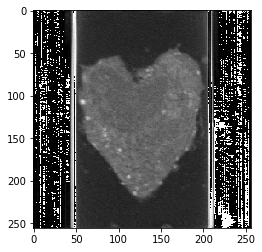

In [41]:
plt.imshow(x[0].squeeze(), cmap="gray")

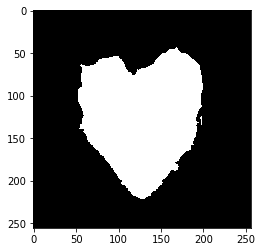

In [42]:
plt.imshow(y[0].squeeze(), cmap="gray")

In [43]:
# test run with UNet model
model = unet()
H = model.fit_generator(trainGenerator(), steps_per_epoch=1, epochs=1)

/Users/JerryQiu/opt/anaconda3/envs/csci527/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/1
Found 1200 images belonging to 1 classes.
Found 1200 images belonging to 1 classes.
1/1 [==============================] - 312s 312s/step - loss: 0.7085 - accuracy: 0.5660


In [45]:
model.save("./model.h5")

In [46]:
# Load existing model and fit for one new data
load_model = load_model('model.h5')

In [53]:
model.weights

[<tf.Variable 'conv2d_169/kernel:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[-0.21059872, -0.01384348,  0.65165615, -0.307117  ,
            0.24908687, -0.78835845,  0.13750699,  0.4114576 ,
            0.15743996, -0.31306103,  0.2655197 , -0.27878195,
            0.14763255,  0.6721238 , -0.55608475,  0.14944284,
            0.41246435, -0.5348907 , -0.21240371, -0.7096845 ,
            0.4277073 ,  0.29219818,  0.10125791, -0.1296831 ,
           -0.58158463,  0.19455656,  0.8531155 , -0.26084343,
            0.33500823,  0.05067705, -0.14116515,  1.008066  ,
            0.02816027, -0.24537739,  0.30587456,  0.55101305,
           -0.05373365, -0.73308223,  0.5644945 , -0.32571414,
            0.47616136, -0.7645011 ,  0.48276   ,  0.8562394 ,
           -0.02132114, -0.4253778 , -0.98729676,  0.1308039 ,
            0.16070443, -0.66415644,  0.36422285,  0.727481  ,
           -0.29710552,  0.7501631 ,  0.47092324, -0.07943469,
           -0.23144871,  0.09175218,  0.

In [52]:
load_model.weights

[<tf.Variable 'conv2d_169_1/kernel:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[-0.21059872, -0.01384348,  0.65165615, -0.307117  ,
            0.24908687, -0.78835845,  0.13750699,  0.4114576 ,
            0.15743996, -0.31306103,  0.2655197 , -0.27878195,
            0.14763255,  0.6721238 , -0.55608475,  0.14944284,
            0.41246435, -0.5348907 , -0.21240371, -0.7096845 ,
            0.4277073 ,  0.29219818,  0.10125791, -0.1296831 ,
           -0.58158463,  0.19455656,  0.8531155 , -0.26084343,
            0.33500823,  0.05067705, -0.14116515,  1.008066  ,
            0.02816027, -0.24537739,  0.30587456,  0.55101305,
           -0.05373365, -0.73308223,  0.5644945 , -0.32571414,
            0.47616136, -0.7645011 ,  0.48276   ,  0.8562394 ,
           -0.02132114, -0.4253778 , -0.98729676,  0.1308039 ,
            0.16070443, -0.66415644,  0.36422285,  0.727481  ,
           -0.29710552,  0.7501631 ,  0.47092324, -0.07943469,
           -0.23144871,  0.09175218,  

In [54]:
load_model.fit(x, y, step=1)

Epoch 1/1
32/32 [==============================] - 328s 10s/step - loss: 0.6932 - accuracy: 0.7263


In [55]:
load_model.weights

[<tf.Variable 'conv2d_169_1/kernel:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[-0.21066532, -0.01390972,  0.65158916, -0.30717337,
            0.24915643, -0.78831303,  0.13757312,  0.41139126,
            0.1575073 , -0.31299806,  0.2655836 , -0.2788437 ,
            0.14756684,  0.67219037, -0.55615085,  0.14937839,
            0.4123969 , -0.5348262 , -0.2124705 , -0.7097377 ,
            0.42764065,  0.29213268,  0.1013246 , -0.12961614,
           -0.58151865,  0.19448994,  0.853182  , -0.26077604,
            0.33507475,  0.05074326, -0.1410987 ,  1.0079993 ,
            0.0280971 , -0.2453178 ,  0.30594146,  0.55094594,
           -0.05366982, -0.7330157 ,  0.5645615 , -0.32564703,
            0.47622818, -0.7645638 ,  0.48282716,  0.8561721 ,
           -0.02138685, -0.4253165 , -0.98729944,  0.1308651 ,
            0.16063784, -0.66409075,  0.36428964,  0.7274143 ,
           -0.29717177,  0.7502301 ,  0.47098958, -0.07936961,
           -0.23138486,  0.09168492,  

In [57]:
load_model.predict(x)

array([[[[0.49995643],
         [0.49995643],
         [0.49995643],
         ...,
         [0.49995643],
         [0.49995643],
         [0.49995643]],

        [[0.49995643],
         [0.49995643],
         [0.49995643],
         ...,
         [0.49995643],
         [0.49995643],
         [0.49995643]],

        [[0.49995643],
         [0.49995643],
         [0.49995643],
         ...,
         [0.49995643],
         [0.49995643],
         [0.49995643]],

        ...,

        [[0.49995643],
         [0.49995643],
         [0.49995643],
         ...,
         [0.49995643],
         [0.49995643],
         [0.49995643]],

        [[0.49995643],
         [0.49995643],
         [0.49995643],
         ...,
         [0.49995643],
         [0.49995643],
         [0.49995643]],

        [[0.49995643],
         [0.49995643],
         [0.49995643],
         ...,
         [0.49995643],
         [0.49995643],
         [0.49995643]]],


       [[[0.50585276],
         [0.49995643],
         [0.49